In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data_generator import *
from utils import *
from cnn import *
from rnn import *
from end2end import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/andreea/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Task 0. Visualize the data

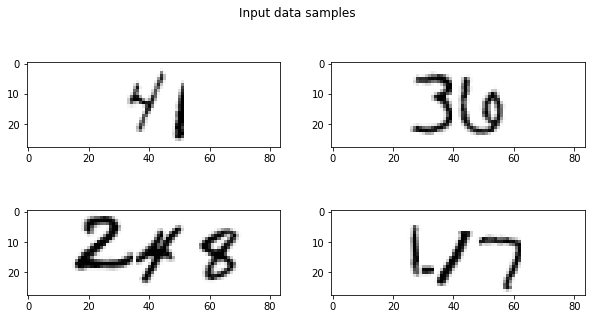

In [3]:
num_samples = 2
generator = test_generator(batch_size=num_samples)
X, numbers, numbers_sum = next(generator)
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(10, 5))
fig.suptitle('Input data samples')
for i in range(num_samples):
    axes[i][0].imshow(X[i, 0, :, :], cmap='Greys')
    axes[i][1].imshow(X[i, 1, :, :], cmap='Greys')

# Solution 1

Segment the image, classify the digits individually using a convolutional neural net and then add the numbers using an encoder-decoder architecture.

### Image segmentation visualization

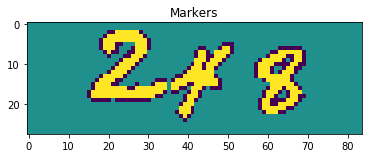

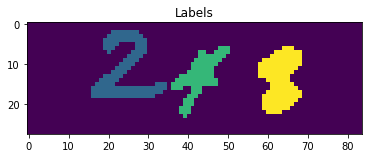

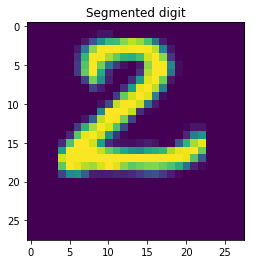

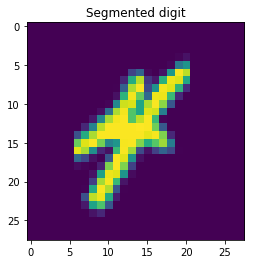

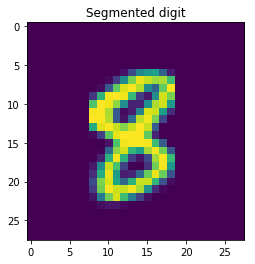

In [10]:
junk = get_each_digit_as_image(X[1, 0, :, :])

### Train a convolutional network on MNIST digits

The network consists of one input layer, followed by two groups consisting of the following:

[CONV, MAX_POOL, RELU, BATCH_NORM]

Two fully connected layers with sizes 128 and 10 follow. In order to get the probability for each class, a softmax layer is added at the end.

The network is trained for 6874 iterations using batches of size 16. It is trained on augmented MNIST data (using the same transformation as in data_generator - otherwise, when simple MNIST is used, the exact match accuracy of the pipeline is about half of the current result). The optimizer used is Adam with the default learning rate (1e-3)

![ceva](https://cdn-images-1.medium.com/fit/t/1600/480/1*cPAmSB9nziZPI73VC5HAHg.png)

Final accuracy: 0.9589999914169312


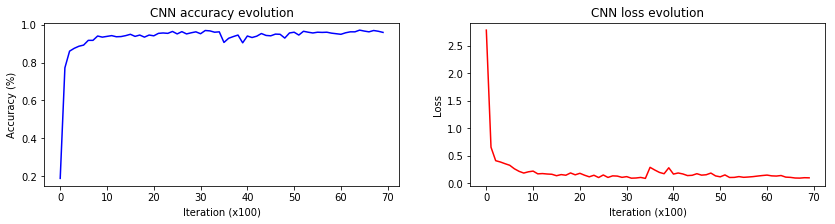

In [6]:
cnn = ConvNet(28, 1, 10)

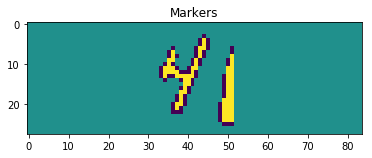

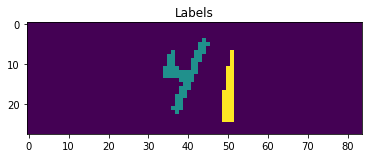

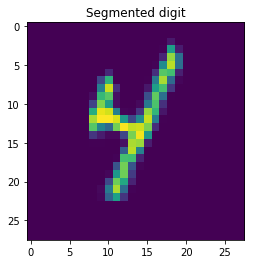

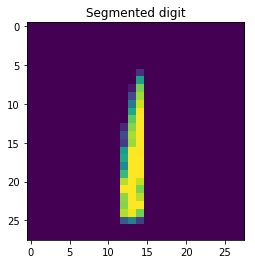

[4 1]


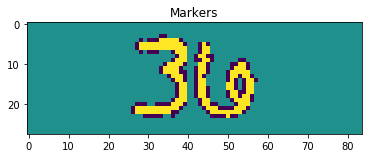

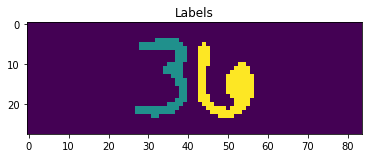

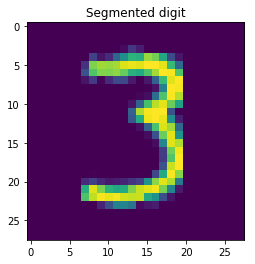

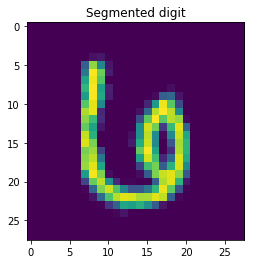

[3 6]


In [13]:
for i in range(1):
    for j in range(2):
        digits = get_each_digit_as_image(X[i, j, :, :], show=True)
        pred = cnn.predict(np.array(digits).reshape(-1, 784))
        print(pred)

### Create a pipeline to predict the number in each picture

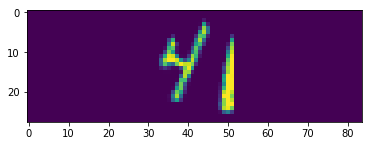

41


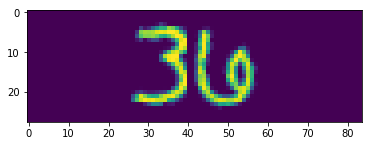

36


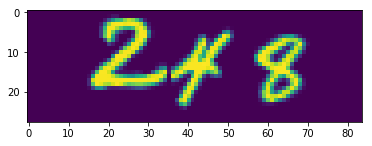

248


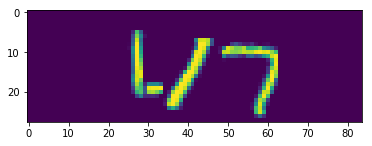

117


In [14]:
imgs = []
for i in range(2):
    imgs.append(X[i, 0, :, :])
    imgs.append(X[i, 1, :, :])
labels = get_numbers(cnn, imgs, show=True)

### Train a recurrent neural network to add numbers

Pad the input sequences (digits of the numbers) so that the length of each sequence is 3 (use 0 as padding). Then add a START_TOKEN and END_TOKEN at the beginning and at the end of each sequence. The input is represented by the one hot encodings of the two padded input sequences obtained from the numbers to be summed, while the target represents the one hot encoding of the sum sequence. The output sequence is generated after processing all the digits from the first number.

Basic LSTM cells are used for creating the recurrent net. A fixed number of timesteps is used (5 = 3 for the digits + 2 for the start and end tokens).

The model is trained for 10000 iterations of training using the Adam optimizer.

![rnn-encoder-decoder](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/Example-of-an-Encoder-Decode-Network.png)

accuracy: 0.03674999997019768
accuracy: 0.3919999897480011
accuracy: 0.39925000071525574
accuracy: 0.43299999833106995
accuracy: 0.4544999897480011
accuracy: 0.4622499942779541
accuracy: 0.4742499887943268
accuracy: 0.47450000047683716
accuracy: 0.47874999046325684
accuracy: 0.49149999022483826
accuracy: 0.5097500085830688
accuracy: 0.4975000023841858
accuracy: 0.5170000195503235
accuracy: 0.5015000104904175
accuracy: 0.5207499861717224
accuracy: 0.5112500190734863
accuracy: 0.5170000195503235
accuracy: 0.5325000286102295
accuracy: 0.5262500047683716
accuracy: 0.5357499718666077
accuracy: 0.5485000014305115
accuracy: 0.5597500205039978
accuracy: 0.550000011920929
accuracy: 0.5580000281333923
accuracy: 0.5772500038146973
accuracy: 0.5832499861717224
accuracy: 0.5759999752044678
accuracy: 0.5927500128746033
accuracy: 0.5895000100135803
accuracy: 0.5997499823570251
accuracy: 0.6060000061988831
accuracy: 0.6027500033378601
accuracy: 0.6237499713897705
accuracy: 0.6117500066757202
accuracy:

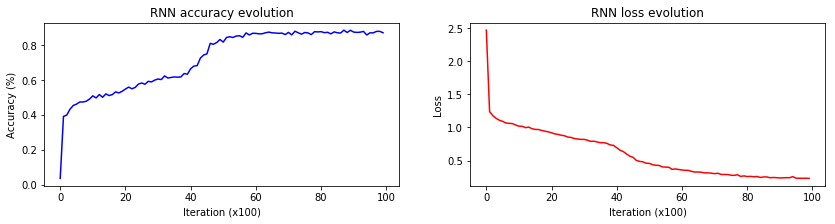

In [7]:
rnn = RecurrentNet(10, hidden_size=200)

### Putting everything together

We do not need the training generator, as each piece the pipeline is trained separately. We can proceed directly to test the pipeline.

We first measure accuracy by computing the exact match for the predicted sum. This is not a good metric, however, 
because a single incorrect digits discards the entire result. We also measure 'digit accuracy' (how many digits were correctly predicted - as a percent).

In [8]:
num_test_data, batch_size = 1024, 16
generator = test_generator(batch_size=num_test_data)
X, numbers, numbers_sum = next(generator)
numbers_sum = [item for sublist in numbers_sum for item in sublist]
num_batches = num_test_data // batch_size
sums_predictions = []
for i in range(num_batches):
    imgs = []
    for j in range(batch_size):
        crt_idx = i * batch_size + j
        imgs = imgs + [X[crt_idx, 0, :, :], X[crt_idx, 1, :, :]]
    labels = list(map(lambda x : x % 1000, get_numbers(cnn, imgs, show=False)))
    predicted = rnn.predict(list(zip(np.array(labels[0::2], dtype=int), np.array(labels[1::2], dtype=int))))
    for j in range(batch_size):
        crt_sum = int(reduce(lambda x, y: 10 * x + y, predicted[j][1:-1]))
        sums_predictions.append(crt_sum)

print('Exact match: {}'.format(compute_exact_match(numbers_sum, list(sums_predictions))))
print('Digit accuracy: {}'.format(compute_digit_accuracy(numbers_sum, list(sums_predictions))))

Exact match: 0.419921875
Digit accuracy: 0.7161458333333334


# Solution 2: An end to end archtecture (Bonus)

Instead of training each piece of the pipeline separately, we can create a model that takes as input the two images, embeds them in a 256-dimensional space using the convolutional network we created above (we remove the last fully connected layer), concatenates them and then feeds them as initial state to an RNN. Then, the recurrent network is trained to predict the next digit of the sum, starting just with the START TOKEN. 

accuracy: 0.13099999725818634
accuracy: 0.24199999868869781
accuracy: 0.2836666703224182
accuracy: 0.2933333218097687
accuracy: 0.31566667556762695
accuracy: 0.3076666593551636
accuracy: 0.32499998807907104
accuracy: 0.3643333315849304
accuracy: 0.3633333444595337
accuracy: 0.37033334374427795
accuracy: 0.3816666603088379
accuracy: 0.4013333320617676
accuracy: 0.398333340883255
accuracy: 0.4086666703224182
accuracy: 0.42633333802223206
accuracy: 0.4346666634082794
accuracy: 0.4266666769981384
accuracy: 0.43066665530204773
accuracy: 0.44866666197776794
accuracy: 0.46566668152809143
accuracy: 0.4573333263397217
accuracy: 0.4873333275318146
accuracy: 0.47866666316986084
accuracy: 0.4833333194255829
accuracy: 0.4936666786670685
accuracy: 0.4963333308696747
accuracy: 0.5106666684150696
accuracy: 0.5116666555404663
accuracy: 0.5136666893959045
accuracy: 0.5163333415985107
accuracy: 0.5296666622161865
accuracy: 0.5163333415985107
accuracy: 0.5373333096504211
accuracy: 0.5433333516120911
accur

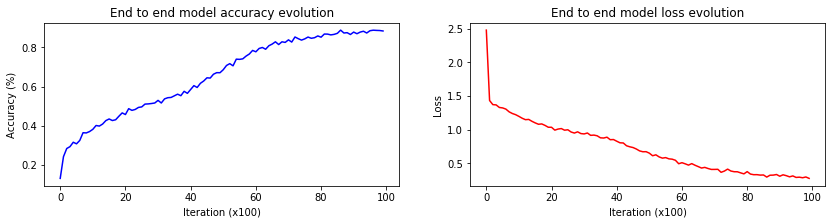

In [9]:
e2e = End2EndAdditionNet(28, 3)

In [10]:
num_samples = 1024
generator = test_generator(batch_size=num_samples)
X, numbers, numbers_sum = next(generator)
numbers_sum = [item for sublist in numbers_sum for item in sublist]
pred = e2e.predict(X)
sums_predictions = list(map(digits_to_number, pred))

print('Exact match: {}'.format(compute_exact_match(numbers_sum, sums_predictions)))
print('Digit accuracy: {}'.format(compute_digit_accuracy(numbers_sum, sums_predictions)))

Exact match: 0.623046875
Digit accuracy: 0.8274739583333334


The performance of the model above could be improved by increasing the number of training iterations or model complexity. Anyway, it has better performance than the first solution, as errors from different levels were accumulating in that model.